# Computer Vision Models in PyTorch

This notebook is based on the tutorial posted [here](https://www.dataquest.io/blog/computer-vision-in-pytorch-part-1/) and [here](https://www.dataquest.io/blog/computer-vision-in-pytorch-part-2/) by Dataquest.

It uses the OOP-based approach of building Computer Vision (CV) models for the following reasons:

- Modularity
- Maintainability
- Flexibility
- Scalability
- Industry alignment

## Defining Model

In [1]:
# package imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import numpy as np
import tarfile
import os
import collections
import random
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from PIL import Image
import seaborn as sns

In [2]:
# subclassing off nn.Module class
# this model will look a pnemonia grayscale images
class PneumoniaCNN(nn.Module):
    def __init__(self):
        super().__init__() # initialization from nn.Module

        # initial size = 256x256
        # as we move through, we decrease size of image but increase
        # feature maps created through convolutions with kernel

        # First convolutional block
        self.conv_block1 = nn.Sequential(
            # 2D convolution operation with kernel (in_channels = 1 for grayscale)
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=32), # training stability
            nn.ReLU(), # adds nonlinearity
            nn.MaxPool2d(kernel_size=2)  # Reduce spatial dimensions by half (128x128)
        )

        # Second convolutional block
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # Further reduce spatial dimensions (64x64)
        )

        # Third convolutional block
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # Further reduce spatial dimensions (32x32)
        )

        # Flatten layer to convert 3D feature maps to 1D vector
        self.flatten = nn.Flatten()

        # Fully connected layers for classification (classification head)
        # 32x32 from last max pool; 128 from last conv2d output channels / spatial maps
        self.fc1 = nn.Linear(in_features=128 * 32 * 32, out_features=512)  # Adjust size based on input dimensions
        self.dropout1 = nn.Dropout(0.5)  # Add 50% dropout for regularization
        self.fc2 = nn.Linear(in_features=512, out_features=128) # another FF layer
        self.dropout2 = nn.Dropout(0.5) # 50% dropout again
        self.fc3 = nn.Linear(in_features=128, out_features=2)  # 2 output classes: Normal and Pneumonia

    def forward(self, x):
        # Pass input through convolutional blocks
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)

        # Flatten the features to connect to dense network
        x = self.flatten(x)

        # Pass through fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        logits = self.fc3(x)  # Raw, unnormalized predictions (final pred.)

        return logits

## Verifying Tensor Shapes

In [3]:
# Create model instance
model = PneumoniaCNN()

# Create a random dummy grayscale image (batch_size, channels, height, width)
dummy_input = torch.randn(1, 1, 256, 256)

In [4]:
# Forward pass function with shape printing to verify operations
def forward_with_shape_printing(model, x):
    print(f"Input shape: \t\t{x.shape}") # Using tabs for alignment

    # Pass through convolutional blocks
    x = model.conv_block1(x)
    print(f"After conv_block1: \t{x.shape}")
    x = model.conv_block2(x)
    print(f"After conv_block2: \t{x.shape}")
    x = model.conv_block3(x)
    print(f"After conv_block3: \t{x.shape}")

    # Flatten the features
    x = model.flatten(x)
    print(f"After flatten: \t\t{x.shape}")

    # Pass through fully connected layers (only showing final output shape)
    x = F.relu(model.fc1(x))
    x = model.dropout1(x)
    x = F.relu(model.fc2(x))
    x = model.dropout2(x)
    logits = model.fc3(x)
    print(f"Output shape (logits): \t{logits.shape}") # Make sure to output preds, not fc3 shape

    return logits

# Run the forward pass (output is ignored with _)
print("Running shape verification pass:")
_ = forward_with_shape_printing(model, dummy_input)

Running shape verification pass:
Input shape: 		torch.Size([1, 1, 256, 256])
After conv_block1: 	torch.Size([1, 32, 128, 128])
After conv_block2: 	torch.Size([1, 64, 64, 64])
After conv_block3: 	torch.Size([1, 128, 32, 32])
After flatten: 		torch.Size([1, 131072])
Output shape (logits): 	torch.Size([1, 2])


## Preparing and Preprocessing the X-ray Image Dataset

In [5]:
import os
import urllib.request

# Example - update this with your actual download URL
url = "https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/xray_dataset.tar.gz"

dataset_path = "dataset.tar.gz" # final path

# Download dataset
if os.path.exists(dataset_path):
    os.remove(dataset_path)

urllib.request.urlretrieve(url, dataset_path)

('dataset.tar.gz', <http.client.HTTPMessage at 0x7bd5f350c7d0>)

In [6]:
# downloaded dataset
dataset_path = "/content/dataset.tar.gz"

# Extract the dataset from gz
with tarfile.open(dataset_path, "r:gz") as tar:
    tar.extractall()
    print("Dataset extracted successfully")

Dataset extracted successfully


## Verifying Dataset Structure and File Counts

In [7]:
# Define base directories relative to your notebook/script location
data_dir = "chest_xray"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Define the classes based on the subfolder names
class_names = ['NORMAL', 'PNEUMONIA']
class_to_idx = {cls_name: i for i, cls_name in enumerate(class_names)}

# Helper function to scan directories, filter JPEG images, and collect paths/labels
def get_image_paths_and_labels(data_dir):
    image_paths = []
    labels = []
    print(f"Scanning directory: {data_dir}")
    for label_name in class_names:
        class_dir = os.path.join(data_dir, label_name)
        count = 0
        # List files in the class directory
        for filename in os.listdir(class_dir):
            # Keep only files ending with .jpeg (case-insensitive)
            if filename.lower().endswith('.jpeg'):
                image_paths.append(os.path.join(class_dir, filename))
                labels.append(class_to_idx[label_name])
                count += 1
        print(f"  Found {count} '.jpeg' images for class '{label_name}'")
    return image_paths, labels

# Get paths and labels for the training set
all_train_paths, all_train_labels = get_image_paths_and_labels(train_dir)
train_counts = collections.Counter(all_train_labels)
total_train_images = len(all_train_paths)

print(f"\nTraining Set Counts:")
print(f"  NORMAL (Class 0): {train_counts[class_to_idx['NORMAL']]}")
print(f"  PNEUMONIA (Class 1): {train_counts[class_to_idx['PNEUMONIA']]}")
print(f"  Total Training Samples: {total_train_images}")

# Get paths and labels for the test set
all_test_paths, all_test_labels = get_image_paths_and_labels(test_dir)
test_counts = collections.Counter(all_test_labels)
total_test_images = len(all_test_paths)

print(f"\nTest Set Counts:")
print(f"  NORMAL (Class 0): {test_counts[class_to_idx['NORMAL']]}")
print(f"  PNEUMONIA (Class 1): {test_counts[class_to_idx['PNEUMONIA']]}")
print(f"  Total Test Samples: {total_test_images}")

Scanning directory: chest_xray/train
  Found 1349 '.jpeg' images for class 'NORMAL'
  Found 3883 '.jpeg' images for class 'PNEUMONIA'

Training Set Counts:
  NORMAL (Class 0): 1349
  PNEUMONIA (Class 1): 3883
  Total Training Samples: 5232
Scanning directory: chest_xray/test
  Found 234 '.jpeg' images for class 'NORMAL'
  Found 390 '.jpeg' images for class 'PNEUMONIA'

Test Set Counts:
  NORMAL (Class 0): 234
  PNEUMONIA (Class 1): 390
  Total Test Samples: 624


## Creating Validation Set

In [8]:
# Define proportion for validation set
val_split_ratio = 0.2
SEED = 42

# Perform stratified split
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_train_paths,
    all_train_labels,
    test_size=val_split_ratio,
    stratify=all_train_labels,
    random_state=SEED
)

# Print the number of samples in each resulting set
print(f"Original training image count: {len(all_train_paths)}")
print(f"--> Split into {len(train_paths)} training samples")
print(f"--> Split into {len(val_paths)} validation samples")

Original training image count: 5232
--> Split into 4185 training samples
--> Split into 1047 validation samples


## Processing Pipelines

In [9]:
# Transformations for the training set (including augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()  # Converts to tensor AND scales to [0, 1]
])

# Transformations for the validation and test sets (NO augmentation)
val_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()  # Converts to tensor AND scales to [0, 1]
])

print("Transformation pipelines defined.")

Transformation pipelines defined.


## Custom PyTorch Dataset

In [10]:
class XRayDataset(Dataset):
    """Custom Dataset for loading X-ray images from file paths."""
    def __init__(self, image_paths, labels, transform=None):
        """
        Args:
            image_paths (list): List of paths to images.
            labels (list): List of corresponding labels (0 or 1).
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Fetches the sample at the given index, loads the image,
        applies transformations, and handles potential errors.

        Args:
            idx (int): The index of the sample to fetch.

        Returns:
            tuple: (image_tensor, label) if successful.
            None: If an error occurs (e.g., file not found, processing error),
                  signalling to skip this sample.
        """
        # Get the path and label for the requested index
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            # Load the image using PIL within a context manager
            with Image.open(img_path) as img:
                # Apply transforms ONLY if they exist
                if self.transform:
                    # Apply the entire transform pipeline
                    image_tensor = self.transform(img)
                    # Return the processed tensor and label
                    return image_tensor, label
                else:
                    # This branch indicates a setup error, as the transform
                    # pipeline should at least contain ToTensor().
                    raise ValueError(f"Dataset initialized without transforms for {img_path}. "
                                     "Transforms (including ToTensor) are required.")

        except FileNotFoundError:
            # Handle cases where the image file doesn't exist
            print(f"Warning: Image file not found at {img_path}. Skipping sample {idx}.")
            return None  # Returning None signals to skip
        except ValueError as e:
            # Catch the specific error we raised for missing transforms
             print(f"Error for sample {idx} at {img_path}: {e}")
             raise e  # Re-raise critical setup errors
        except Exception as e:
            # Catch any other PIL loading or transform errors
            print(f"Warning: Error processing image {img_path} (sample {idx}): {e}. Skipping sample.")
            return None  # Returning None signals to skip

## Final Datasets

In [11]:
# Instantiate the custom Dataset for each split
train_dataset = XRayDataset(
    image_paths=train_paths,
    labels=train_labels,
    transform=train_transforms     # Apply training transforms (incl. augmentation)
)

val_dataset = XRayDataset(
    image_paths=val_paths,
    labels=val_labels,
    transform=val_test_transforms  # Apply validation transforms (no augmentation)
)

test_dataset = XRayDataset(
    image_paths=all_test_paths,    # Using all_test_paths from verification step
    labels=all_test_labels,        # Using all_test_labels from verification step
    transform=val_test_transforms  # Apply validation/test transforms
)

# Print dataset sizes to confirm
print("\nFinal Dataset objects created:")
print(f"  Training dataset size:   {len(train_dataset)}")
print(f"  Validation dataset size: {len(val_dataset)}")
print(f"  Test dataset size:       {len(test_dataset)}")


Final Dataset objects created:
  Training dataset size:   4185
  Validation dataset size: 1047
  Test dataset size:       624


## DataLoader Objects

In [12]:
# Define batch size (can be tuned depending on GPU memory or CPU capacity)
batch_size = 32

# Create DataLoader for the training set
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,        # Shuffle data each epoch for training
    num_workers=2,       # Number of subprocesses to use for data loading (adjust based on system)
    pin_memory=True      # Speeds up CPU-GPU transfer if using CUDA
)

# Create DataLoader for the validation set
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,       # No need to shuffle validation data
    num_workers=2,
    pin_memory=True
)

# Create DataLoader for the test set
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,       # No need to shuffle test data
    num_workers=2,
    pin_memory=True
)

print(f"\nDataLoaders created with batch size {batch_size}.")


DataLoaders created with batch size 32.


## Visualizing Sample Images


Visualizing a batch from train_loader...


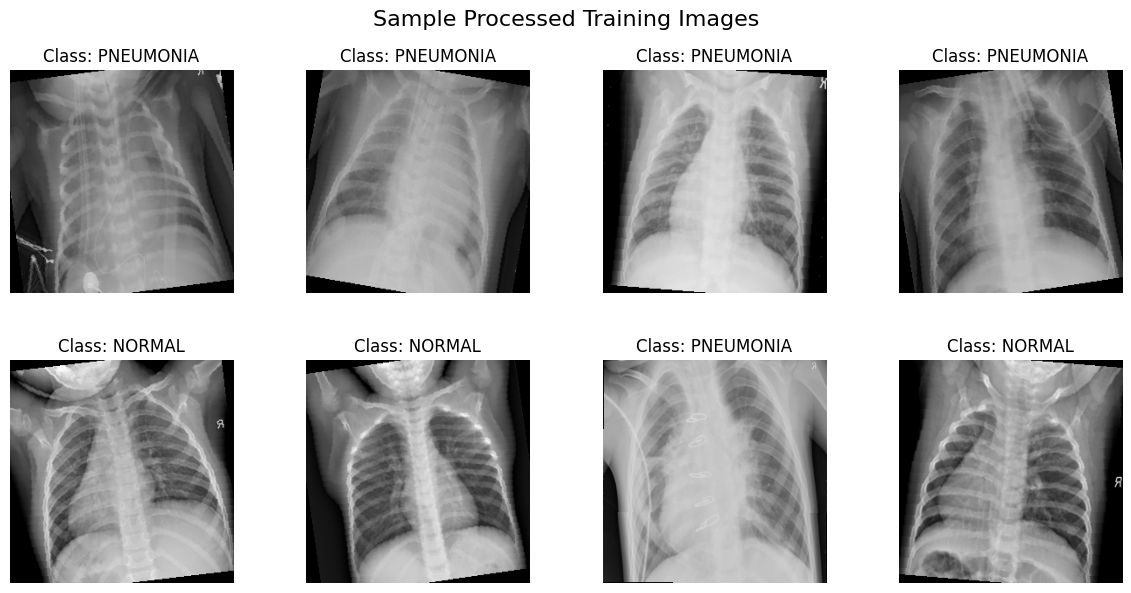


Visualizing a batch from val_loader...


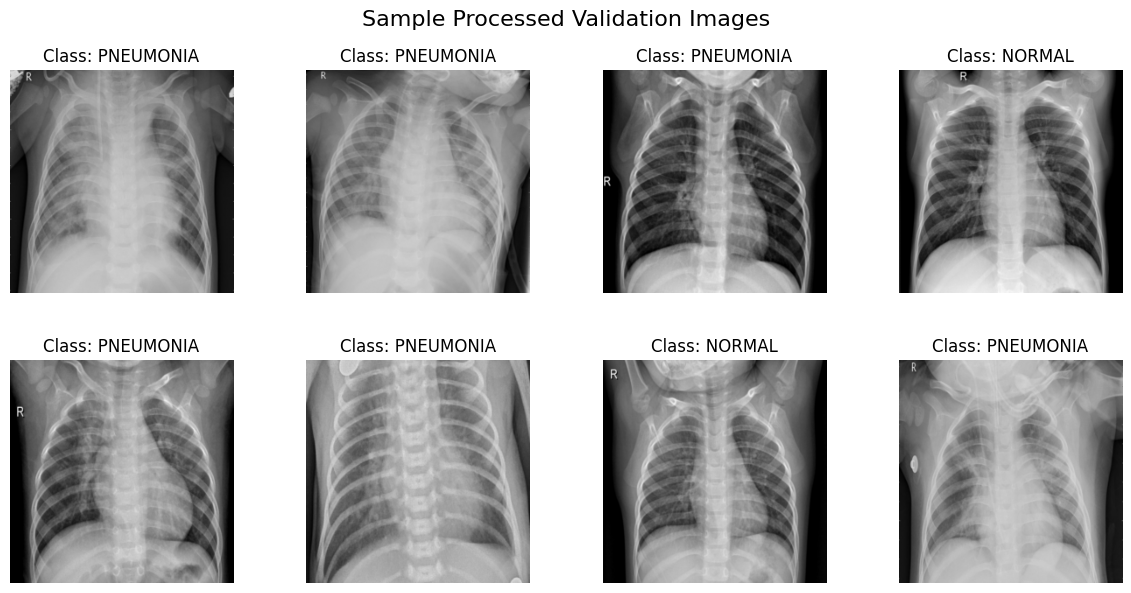

In [13]:
def show_batch(dataloader, class_names, title="Sample Batch", n_samples=8):
    """Displays a batch of transformed images from a DataLoader."""
    try:
        images, labels = next(iter(dataloader))  # Get one batch
    except StopIteration:
        print("DataLoader is empty or exhausted.")
        return

    # Limit number of samples to display if batch is smaller than n_samples
    actual_samples = min(n_samples, images.size(0))
    if actual_samples <= 0:
        print("No samples found in the batch to display.")
        return
    images = images[:actual_samples]
    labels = labels[:actual_samples]

    # Tensors are likely on GPU if device='cuda', move to CPU for numpy/plotting
    images = images.cpu()
    labels = labels.cpu()

    # Determine subplot layout
    if actual_samples <= 4:
        ncols = actual_samples; nrows = 1; figsize = (3 * ncols, 4)
    else:
        ncols = 4; nrows = 2; figsize = (12, 6)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    if nrows == 1 and ncols == 1: axes = np.array([axes])  # Handle single plot case
    axes = axes.flatten()  # Flatten axes array for easy iteration
    fig.suptitle(title, fontsize=16)

    for i in range(actual_samples):
        ax = axes[i]
        img_tensor = images[i]  # Shape is [C=1, H, W], scaled [0.0, 1.0]

        # Reminder: ToTensor scaled pixels to [0, 1]
        # Matplotlib can directly display tensors in this range with cmap='gray'

        # Permute dimensions from [C, H, W] to [H, W, C] for matplotlib
        img_display = img_tensor.permute(1, 2, 0).numpy()

        # Display the image, removing the channel dimension using squeeze() for grayscale
        # Specify vmin/vmax ensures correct display range for float data
        ax.imshow(img_display.squeeze(), cmap='gray', vmin=0.0, vmax=1.0)
        ax.set_title(f"Class: {class_names[labels[i]]}")  # Use passed class_names
        ax.axis('off')

    # Hide any unused subplots if the grid is larger than needed
    for j in range(actual_samples, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.88 if title else 0.95, hspace=0.3) # Adjust for suptitle
    plt.show()

# Visualize training samples (should show augmentations)
print("\nVisualizing a batch from train_loader...")
show_batch(train_loader, class_names, title="Sample Processed Training Images")

# Visualize validation samples (should NOT show augmentations)
print("\nVisualizing a batch from val_loader...")
show_batch(val_loader, class_names, title="Sample Processed Validation Images")

## Training CNN Model

In [14]:
# Instantiate the model
model = PneumoniaCNN()

# Check if CUDA (GPU support) is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the chosen device (GPU or CPU)
model.to(device)

print(f"Model '{type(model).__name__}' instantiated and moved to '{device}'.")

Model 'PneumoniaCNN' instantiated and moved to 'cuda'.


## Define the Loss Function and Optimizer

In [15]:
# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

print("Loss function and optimizer defined.")

Loss function and optimizer defined.


## Training Loop

In [16]:
def train_model(model, train_loader, val_loader, criterion,
                optimizer, device, num_epochs=20):
    """Trains and validates the model."""
    # Initialize lists to track metrics as empty lists
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    print("Starting Training...")
    # Training loop
    for epoch in range(num_epochs):
        # Training Phase
        model.train()  # Set model to training mode (enables dropout, batch norm updates)
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Iterate over training data
        for i, (images, labels) in enumerate(train_loader):
            # Move data to the specified device
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images) # forward pass
            loss = criterion(outputs, labels) # calc loss

            # Backward pass and optimize
            loss.backward() # backprop
            optimizer.step() # update params via optimizer

            # Track training loss and accuracy
            # total batch loss
            running_loss += loss.item() * images.size(0)  # loss.item() is the avg loss per batch

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Calculate training statistics for the epoch
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # Validation Phase
        model.eval()  # Set model to evaluation mode (disables dropout, uses running stats for batch norm)
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        # Disable gradient calculations for validation (no params updated)
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        # Calculate validation statistics for the epoch
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = correct_val / total_val
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        # Print statistics for the epoch
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
        print(f"  Val Loss:   {epoch_val_loss:.4f}, Val Acc:   {epoch_val_acc:.4f}")
        print("-" * 30)

    print("Finished Training.")
    # Return performance history as a dict
    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies
    }

## Train Model

In [21]:
# Train the model
num_epochs = 20

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs
)

Starting Training...
Epoch 1/20
  Train Loss: 0.1092, Train Acc: 0.9589
  Val Loss:   0.0617, Val Acc:   0.9761
------------------------------
Epoch 2/20
  Train Loss: 0.0967, Train Acc: 0.9613
  Val Loss:   0.0570, Val Acc:   0.9761
------------------------------
Epoch 3/20
  Train Loss: 0.0946, Train Acc: 0.9668
  Val Loss:   0.0645, Val Acc:   0.9761
------------------------------
Epoch 4/20
  Train Loss: 0.0990, Train Acc: 0.9642
  Val Loss:   0.0689, Val Acc:   0.9771
------------------------------
Epoch 5/20
  Train Loss: 0.0958, Train Acc: 0.9673
  Val Loss:   0.0561, Val Acc:   0.9809
------------------------------
Epoch 6/20
  Train Loss: 0.0967, Train Acc: 0.9663
  Val Loss:   0.0527, Val Acc:   0.9799
------------------------------
Epoch 7/20
  Train Loss: 0.0853, Train Acc: 0.9697
  Val Loss:   0.0594, Val Acc:   0.9752
------------------------------
Epoch 8/20
  Train Loss: 0.0821, Train Acc: 0.9701
  Val Loss:   0.0496, Val Acc:   0.9809
------------------------------
Epo

## Visualizing the Training Process

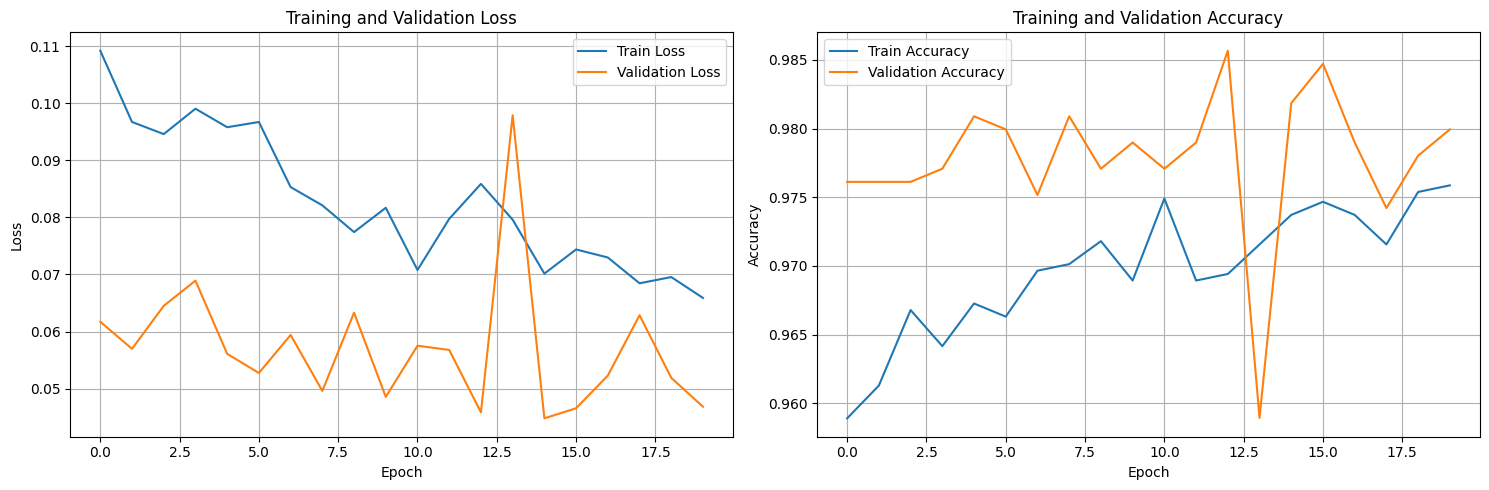

In [22]:
def plot_training_history(history):
    """Plots the training and validation loss and accuracy."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(history['train_losses'], label='Train Loss')
    ax1.plot(history['val_losses'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracies
    ax2.plot(history['train_accuracies'], label='Train Accuracy')
    ax2.plot(history['val_accuracies'], label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Plot the training and validation history
plot_training_history(history)

## Evaluating Model

In [23]:
def evaluate_model(model, test_loader, device, class_names):
    """
    Evaluates the model on a given dataloader (e.g., test set).

    Computes confusion matrix and classification report.
    """
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Calculate classification report
    class_report = classification_report(
        all_labels, all_preds,
        target_names=class_names,
        digits=4,
        zero_division=0
    )

    # Calculate overall accuracy from the report
    accuracy = np.trace(cm) / np.sum(cm)  # Simple accuracy from confusion matrix

    return {
        'confusion_matrix': cm,
        'classification_report': class_report,
        'accuracy': accuracy,
        'predictions': all_preds,
        'true_labels': all_labels
    }

# Evaluate the model
eval_results = evaluate_model(model, test_loader, device, class_names)

# Print results
print("Classification Report:")
print(eval_results['classification_report'])
print(f"\nOverall Accuracy: {eval_results['accuracy']:.4f}")

Classification Report:
              precision    recall  f1-score   support

      NORMAL     0.9722    0.2991    0.4575       234
   PNEUMONIA     0.7029    0.9949    0.8238       390

    accuracy                         0.7340       624
   macro avg     0.8376    0.6470    0.6406       624
weighted avg     0.8039    0.7340    0.6864       624


Overall Accuracy: 0.7340


## Visualize Confusion Matrix

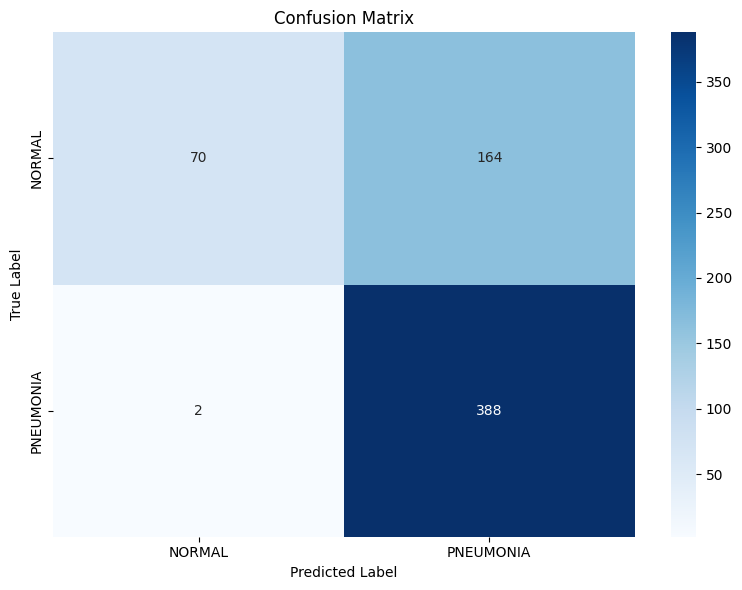

In [24]:
def plot_confusion_matrix(confusion_matrix, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        confusion_matrix,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(eval_results['confusion_matrix'], class_names)

We notice here that the model appears to be biased towards the pneumonia class, predicting that label far more frequently than the normal class.

This results in a high number of false positives for pneumonia (Type I errors), but very few false negatives (Type II errors). In medical scenarios, minimizing Type II errors is often preferred because failing to detect a true illness like pneumonia can have serious consequences. However, the trade-off is a large number of unnecessary pneumonia diagnoses.

The model achieves high recall for pneumonia but struggles with recall for the normal class. Despite this, precision remains reasonably strong, especially for pneumonia.

To address this imbalance, more advanced techniques could be explored, such as synthetic data generation (such as SMOTE), class weighting in the loss function, or collecting more normal class samples to balance the dataset.

## Visualize Model Predictions


Visualizing sample predictions from the test set...


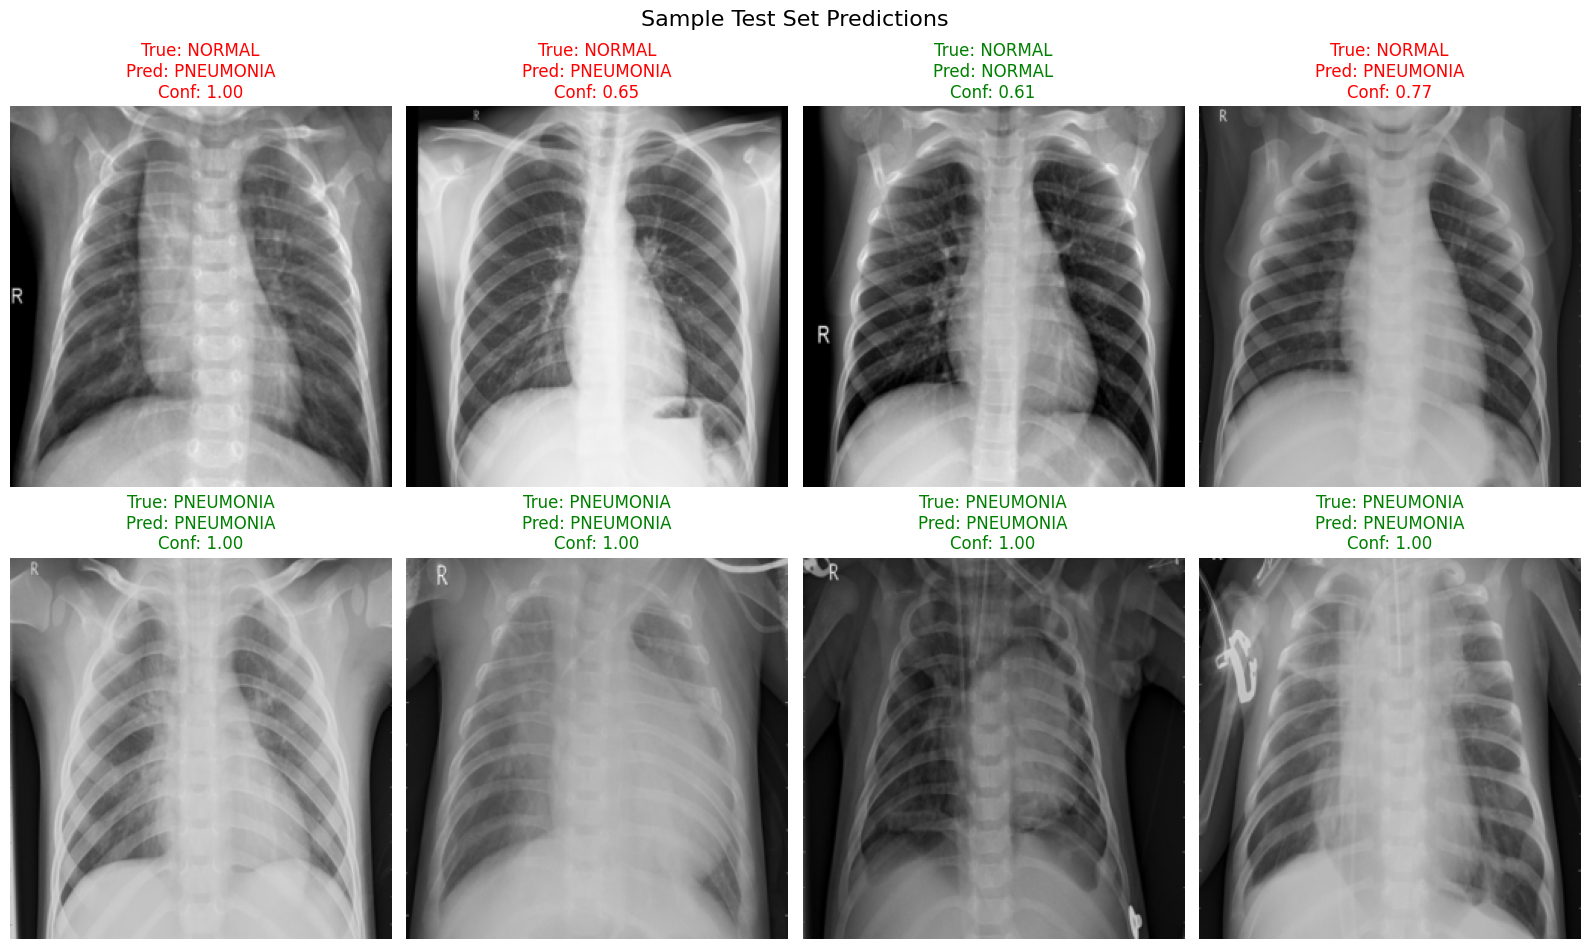

In [25]:
def visualize_predictions(model, dataloader, device, class_names, num_samples=8):
    """Displays a batch of test images with their true labels and model predictions."""
    model.eval()
    try:
        images, labels = next(iter(dataloader))
    except StopIteration:
        print("DataLoader is empty.")
        return

    # Ensure we don't request more samples than available in the batch
    actual_samples = min(num_samples, images.size(0))
    if actual_samples <= 0:
        print("No samples in batch to display.")
        return
    images, labels = images[:actual_samples], labels[:actual_samples]

    images_device = images.to(device)  # Move input data to the correct device

    # Get model predictions
    with torch.no_grad():
        outputs = model(images_device)
        _, preds = torch.max(outputs, 1)
        probs = F.softmax(outputs, dim=1)

    # Move data back to CPU for plotting
    preds = preds.cpu().numpy()
    probs = probs.cpu().numpy()
    images = images.cpu()

    # Determine subplot layout
    if actual_samples <= 4:
         ncols = actual_samples; nrows = 1; figsize = (4 * ncols, 5)
    else:
         ncols = 4; nrows = 2; figsize = (16, 10)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    # Ensure axes is iterable
    if nrows == 1 and ncols == 1: axes = np.array([axes])
    axes = axes.flatten()
    fig.suptitle("Sample Test Set Predictions", fontsize=16)

    for i, ax in enumerate(axes):
         if i < actual_samples:
             img_tensor = images[i]
             true_label = class_names[labels[i]]
             pred_label = class_names[preds[i]]
             confidence = probs[i][preds[i]]

             # Prepare image for display (C, H, W) -> (H, W, C)
             img_display = img_tensor.permute(1, 2, 0).numpy()

             # Display image
             ax.imshow(img_display.squeeze(), cmap='gray', vmin=0.0, vmax=1.0)

             # Set title with prediction info and color coding
             title_color = 'green' if pred_label == true_label else 'red'
             title = f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}"
             ax.set_title(title, color=title_color)
             ax.axis('off')
         else:
             ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Adjust layout for suptitle
    plt.show()

# Visualize model predictions on the test set
print("\nVisualizing sample predictions from the test set...")
# Create a TEMPORARY DataLoader with shuffling enabled JUST for visualization
# This helps ensure we see a mix of classes in the first batch we grab.
# The 'test_loader' used for actual evaluation remains unshuffled.
temp_vis_loader = DataLoader(
    dataset=test_dataset,  # Use the same test_dataset
    batch_size=batch_size, # Use the same batch size
    shuffle=True           # Shuffle ON for this temporary loader
)
visualize_predictions(model, temp_vis_loader, device, class_names)